<a href="https://colab.research.google.com/github/LeonBusche/AIMA-personal-repo-LeonBusche-/blob/main/week_04_medical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2 - Machine Learning in PyTorch

In preparation for the coming lessons, we want to work on a machine with GPUs. To switch to one (if one is available), click on `Runtime` > `Change runtime type` and select a runtime which includes a GPU.

**This week's exercise has 3 tasks for a total of 6 points. Don't forget to submit your solutions to GitHub!**

Since the overall goal for students of this seminar is to become capable of solving practical tasks in *modern* medical machine learning, we will have to learn model building and training with a modern machine learning library - PyTorch. Before we can do that, we need a few "tools to put in our toolbox". We will reuse these tools in the coming weeks. In this chapter, we want you to become proficient at the following tasks:

- Handling medical data in different formats
- Visualizing different medical data
- Using PyTorch tensors
- Building a PyTorch dataset, using medical data

The code you see below is code for a standard bash terminal, which downloads some data for us (and which you do not need to learn). Colab offers a friendly way to execute such terminal commands directly from our notebook, by putting a `!` before them:

In [ ]:
import gdown

# Get QIN LUNG CT
!pip install idc-index -q
!gdown 1qBSweWSIMxhpsq1MEQIQk8wpr5lbnfE8
!idc download ./manifest_20250930_060727_aws.s5cmd
!find ./qin_lung_ct/ -depth -name 'SEG_*' -exec rm -rf {} \;

# Get LiTS-PNG
!gdown 1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
!rm -rf ./sample_data/
!unzip -qq Clean_LiTS.zip
!rm ./Clean_LiTS.zip

Much like on a home computer, you can see and browse through the files we downloaded in a file browser. To access this file browser, look to the left of the code, and click on the little folder symbol.

#### Chapter 2.1 - Reading and visualizing medical data

Medical data can come in a variety of formats. In this chapter, we will look at the two most common ones in medical imaging: DICOM files and regular image files (e.g. JPG/PNG).

As example data, we have downloaded two sets of data, the QIN LUNG CT dataset (https://doi.org/10.7937/K9/TCIA.2015.NPGZYZBZ, acquired from the TCIA via https://portal.imaging.datacommons.cancer.gov/explore) for DICOM files, and the LiTS 2017 dataset (https://doi.org/10.1016/j.media.2022.102680, acquired via Kaggle at https://www.kaggle.com/datasets/andrewmvd/lits-png).

**DICOM Files** - DICOM files are files that adhere to the DICOM standard (https://www.dicomstandard.org/). Typically, a DICOM file contains two important things:
- a header section, which is basically one large, standardized dictionary containing meta information like patient name (anonymized here), age, the hospital location, what kind of study was performed and on what body part, and a ton of other things.
- a data section called "pixel_array", which typically holds one 2D image.

Typically, DICOM files are structured like this:
- One DICOM file holds a single 2D image
- If the overall image is supposed to be 3D, like in CT images or MR images, the 3D image is split into 2D *slices*, and each slice has its own DICOM file. All of these have the same header information, but different image information
- However many files are needed to have a full scan - 1 for an X-ray image, and sometimes up to 1000 for a really detailed CT - these files together make up what is called a *series*.
- A *study* consists of one or several series. You can think of it as a single session, e.g. having injured your ribs in a car crash, the hospital is making several X-rays of your chest, one in a frontal view, and one in a lateral view.
- The typical folder structure for DICOM files looks something like this: Each patient has a folder, each study of that patient has a sub-folder in that folder, and each series in a study has a sub-sub-folder, which is filled with our .dcm files.

Let's look at an example file.

In [ ]:
!pip install pydicom

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom as pdc

# pydicom's dcmread function can be used to open a DICOM file like so:
meta = pdc.dcmread("./qin_lung_ct/QIN-LSC-0003/1.3.6.1.4.1.14519.5.2.1.4320.7007.203059346048546067166621241946/CT_1.3.6.1.4.1.14519.5.2.1.4320.7007.113686129632252779806152571225/0243eb18-d571-450d-a665-0c62ac7df9c0.dcm")

# DICOM files
print(meta)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 194
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.4320.7007.297213050575420570213687379381
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.34'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.4320.7007.297213050575420570213687379381
(0008,0020) Study Date                          DA: '20030806'
(0008,0021) Series Date     

As you can see, DICOM files contain a lot of information, structured like a dictionary. You can find a list of all DICOM tags, which are the keys of this dictionary here: https://www.dicomlibrary.com/dicom/dicom-tags/.

We can access parts of the header, e.g. the modality (CT) like this:

In [9]:
# Information can be accessed by DICOM tag number
modality = meta[0x0008, 0x0060]
print(modality)

# or by DICOM tag name
modality = meta["Modality"]
print(modality)

# Any object - or DataElement - we get from this isn't quite one of the usual Python types
print(type(modality))

# But we can get the usual native Python types by accessing the value of the object
print(modality.value, type(modality.value))

(0008,0060) Modality                            CS: 'CT'
(0008,0060) Modality                            CS: 'CT'
<class 'pydicom.dataelem.DataElement'>
CT <class 'str'>


We can also grab the image itself from the DICOM file like this:

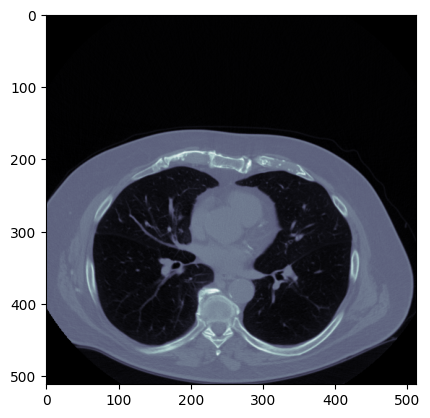

In [24]:
image = meta.pixel_array
plt.imshow(image, cmap = "bone")

Now it's time for a little exercise, to get comfortable with the data format.

**Task 1 (1 point)**: Go through the QIN LUNG CT dataset, and calculate the average slice thickness of each scan by extracting the information from the DICOM header.

In [42]:
# Habe ne coole funktion gefunden, die automatisch den verzeichnis baum durchsucht / alternativly I could hve used something like os.walk and/or os.join
from pathlib import Path

root_dir = Path("./qin_lung_ct")
sliceThick_arr= []
for dcm_path in root_dir.rglob("*.dcm"):
    meta = pdc.dcmread(dcm_path)
    sliceThick= meta.SliceThickness
    sliceThick_arr.append(sliceThick)

sliceThick_average = np.mean(sliceThick_arr)
print(sliceThick_average)

4.306461810824482


**JPEG/PNG**

For this lesson, and later computer vision lessons, we will work with a dataset called `LiTS 2017`. LiTS is shorthand for "**Li**ver **T**umor **S**egmentation". It contains computed tomography (CT) images, once again split into 2D slices, and the goal in the LiTS challenge was to make a neural network accurately locate the liver as well as any tumors, in those images.

Later on, we will first try to classify the images into three categories: No Liver Visible, Liver Visible, and Liver Tumor Visible. We will later also try to solve the segmentation challenge with our neural networks, i.e. painting in the actual areas in the image that contain liver tissue or tumors (lesions).

Unlike the DICOM files from before, JPEG/PNG files do not contain the exhaustive meta information stored in the DICOM header - just the image itself. As such, there is nothing you need to learn, except opening them, and then using or visualizing the data.

In [43]:
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch, torchvision

# Let's first load an image. For this purpose, we use PIL ('Pillow'),
# which can read jpg or png images from the disk.
with PIL.Image.open("./Clean_LiTS/train/volume-10_337.png") as f:

    # Now we grab the array from the image.
    img_array = np.array(f, dtype = np.uint8)

# Let's see what size our image is.
print(img_array.shape)

(256, 256, 3)


(0.0, 256.0)

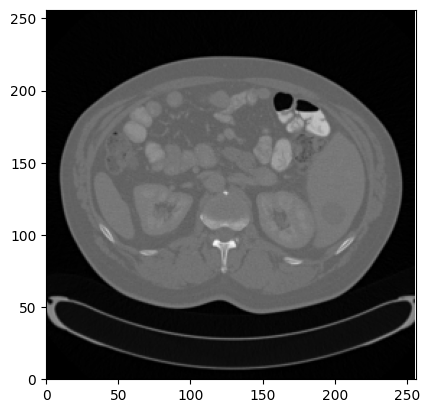

In [44]:
# We can already visualize the image using matplotlib
plt.figure()
plt.imshow(img_array)
plt.xlim((0, 256))
plt.ylim((0, 256))

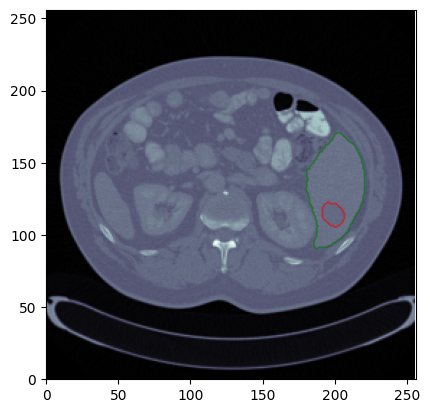

In [45]:
# Lets make our plot look a little nicer.

# Let us first load the image
with PIL.Image.open("./Clean_LiTS/train/volume-10_337.png") as f:

    # This time, we convert the image to grayscale immediately.
    # It always was already grayscale in a sense, but had 3 channels - RGB.
    f = f.convert("L")
    # Now it has 1.

    # We again grab the array from the image.
    img_array = np.array(f, dtype = np.uint8)

# This time, we also load the segmentation of the liver and potential tumors.
# Think of it as a map of where in the image something - e.g. the liver or a
# tumor - can be found:
with PIL.Image.open("./Clean_LiTS/train/segmentation-10_livermask_337.png") as f:
    f = f.convert("L")
    liver = np.array(f, dtype = np.uint8)
with PIL.Image.open("./Clean_LiTS/train/segmentation-10_lesionmask_337.png") as f:
    f = f.convert("L")
    tumors = np.array(f, dtype = np.uint8)

# We make what is called a meshgrid - they are a tool designed for exactly the
# kind of plot that we are making right now. A meshgrid is essentially every
# combination of x and y coordinates in our image.
X, Y = np.meshgrid(np.arange(256), np.arange(256))
plt.figure()
# We show the image again, but since we only have one channel now,
# we get to use colormaps, which look a lot nicer than regular grayscale images.
plt.imshow(img_array, cmap = "bone")
plt.xlim((0, 256))
plt.ylim((0, 256))
# We can draw the 'truth' into our image with the help of the countour function
plt.contour(X, Y, liver, colors = "g", alpha = 0.25, linewidths = 0.5)
plt.contour(X, Y, tumors, colors = "r", alpha = 0.25, linewidths = 0.5)

#### Chapter 2.2 - PyTorch Tensors

We will now introduce a Python package called PyTorch. Besides TensorFlow, it is probably *the* premier machine learning environment. It comes with a lot of features and a couple things that may trip up new users. Therefore, we will try to slowly ease ourselves into using PyTorch.

The `Tensor` sits at the heart of the PyTorch package. A tensor in machine learning is basically the same as an n-dimensional matrix. Under the hood, tensors work almost the same way as the numpy arrays we already know. However, tensors come with a couple of additional functionalities. Attached to each tensor is information about the data type it contains, the device it currently resides in (for example the regular memory, or the memory of a GPU), and most importantly information about its gradients. We will come back to the last bit later on.

In [46]:
import torch
import numpy as np

# How do we make a tensor? Essentially the same as a numpy array.
my_tensor = torch.tensor([1, 2, 3])
print(my_tensor)

tensor([1, 2, 3])


In [ ]:
# In fact, we can even make a numpy array into a tensor:
my_array = np.array([2, 3, 4, 5])
my_tensor = torch.tensor(my_array)
print(my_tensor)

In [ ]:
# We can also get back our numpy array from a tensor:
my_array = my_tensor.numpy()
print(my_array)

In [ ]:
# Tensors come with most of the same functionality as numpy arrays, such as
# Knowing its own dimensions
my_tensor = torch.zeros((1, 4))
print(my_tensor.size())

In [ ]:
# Transposition
print(my_tensor.T)

In [ ]:
# Reshaping
print(my_tensor.reshape((2, 2)))

In [ ]:
# Flattening
print(my_tensor.flatten())

In [ ]:
# Operations along an axis
my_tensor = torch.tensor([[1, 2], [4, 3]])
print(my_tensor.argmax(axis=0))
print(my_tensor.argmax(axis=1))
# and so on.

In [ ]:
# Occasionally, you will come across tensors with only one component.
# These are still, technically, a sort of matrix. However, you can turn
# them into just a regular scalar if need be:
t = torch.tensor(1)
print(t)
print(t.item())

# As you may have already noticed, the syntax of the tensor operations is
# almost the same as that for numpy arrays, but not always exactly the same.
# Don't worry - PyTorch is well-documented. If you know what you want,
# you can find it on Google or their documentation website.

In [ ]:
# Tensors know where they currently live.
# This attribute of a tensor is called 'device'.
my_tensor = torch.tensor([[1, 2], [3, 4]])
print(my_tensor.device)

# We can manually move tensors and other PyTorch objects around on devices.
# We do so with the '.to' method. The method expects the name of the device
# we send it to. This could be "cpu", "cuda", or something like "cuda:0".

# 'cuda' is the name of the engine under the hood, so to speak, and when we
# specify 'cuda' as the target device, our tensor is put into the memory of
# a GPU. If we specify the number, we select the nth GPU specifically.
my_tensor = my_tensor.to("cuda:0")
print(my_tensor.device)

# If you don't know whether you have a GPU available, you can even check:
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"
my_tensor = my_tensor.to(device)
print(device, my_tensor.device)

#### Chapter 2.3 - The PyTorch Recipe

Machine learning in PyTorch commonly follows a very specific pattern. The more sophisticated your training algorithm and the more complex your data, the more you will eventually move away from this recipe. Conceptually, however, the steps remain largely the same:

- I) Take some input images and do some preprocessing to them. This includes things such as guaranteeing the images to all have the same shape, cutting off uninteresting parts of the image, or performing image augmentations like adding noise (we will learn more about this later on).
- II) Feed them to the GPU, if we have one.
- III) Let the model make some predictions from our data.
- IV) Compute the loss, given our predictions and the ground truths. ("How wrong were my predictions?")
- V) Derive the gradients of the model parameters with respect to the loss. ("In which direction must my parameters move to decrease my loss and thereby improve earlier predictions?")
- VI) Move all model parameters into this direction for a certain distance. ("Ask, how far must I go in this direction, then go.")
- VII) Repeat 1-6 until the predictions become good.
- VIII) Occasionally validate your performance on previously unseen data to check whether they are good.
- IX) Finally, evaluate the model on previously unseen data. This is the final result, and the thing reported in papers.

For now, we will go through the recipe and get an understanding of what we have to do and why. Most of what you see should be familiar to you because of the lecture. Once we understand everything, we will start building all the components ourselves to get the hang of coding in PyTorch.

If something does not work later on, it can always be good to go back to the recipe and try to see what the recipe does that you maybe don't.

In [ ]:
"""
As promised, this ready-to-go example will actually train something,
although it is not particularly sophisticated. Try to execute it,
and try to follow what each part of the code does!

1) Imports
First, we handle our imports. Typically we do this at the top of our
program. If looking at the text starts bothering you because it is so
much, you are free to delete it or edit it. If you ever need it again,
the original is still on GitHub.
"""

import torch, torchvision

# We also check if CUDA (read: at least one GPU) is available
device = ("cuda" if torch.cuda.is_available() else "cpu")

"""
2) The Dataset
PyTorch has specific requirements that datasets need to fulfill.
A dataset is a class and it handles your data (surprise). In the
next chapter, we will make our own, and we will discuss in more
detail what actually needs to be done to replace one.

For now, we will stick with a pre-existing one, called CIFAR10,
which already exists. CIFAR10 contains images of flowers, which we
want to try and classify. Once you understand the recipe, we will
replace CIFAR10 with medical data, and you will make the dataset
yourself.

(Since someone thought it would be a fantastic idea for the dataset to
return PIL Images instead of tensors, we add a ToTensor transform. We
will come back to transforms and how to use them later. For now, you
don't have to concern yourself with that.)

Finally, since we will want to gain an understanding of the actual
performance we have reached, we will split our dataset into a train,
validation, and test set, containing 80%, 10% and 10% of the data
respectively. This lets us
"""
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Ignore this bit for now
dataset = torchvision.datasets.CIFAR10("../data/CIFAR10/", download = True, transform = transforms)
dl = len(dataset)
train_set, val_set, test_set = torch.utils.data.random_split(dataset = dataset, lengths = [int(0.8*dl), int(0.1*dl), int(0.1*dl)])

# 3) The Dataloader
"""
A dataloader wraps a dataset. For the most part, it just grabs random
data points from your dataset and glues the tensors together along the
first dimension and then returns them. We will discuss the options that
the dataloader affords us in more detail below, but we will not have to
write our own.

Example: If your data is comprised of 256x256 pixel images, and your
batch size is 32, then your dataset might return a 256x256 tensor,
while the dataloader would tell its 4 workers "I need 32 images", gets
8 from each worker, and returns to you a size 32x256x256 tensor.
"""

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    num_workers = 4,
    shuffle = True,
    drop_last = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_set,
    batch_size = batch_size,
    num_workers = 0,
    shuffle = False,
    drop_last = False
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_set,
    batch_size = batch_size,
    num_workers = 0,
    shuffle = False,
    drop_last = False
    )

# 4) The Model
"""
If machine learning is a meal, then the model is the meat. In a sense,
the mathematical operations a model can perform are completely arbitrary,
so long as they are almost everywhere  differentiable (and some of them
are non-linear), so that normal gradient descent can be performed. A
model simply takes some tensor(s) as input and uses that input and its
own model parameters to create some output tensor(s). We will revisit
models, how they typically look, why they look like that - and how we can
make some fairly powerful ones ourselves - next week.

For the moment, we will simply pick up a pre-existing model and not make
one ourselves. The only thing we change is the final layer of the model,
since the model was originally designed for different data. Don't concern
yourself with that last step for now, we will come back to this.
"""
model = torchvision.models.resnet50(pretrained = True)
model.fc = torch.nn.Linear(model.fc.in_features, 10) # Ignore me
model = model.to(device)

# 5) The Loss function
"""
Models typically learn by creating some output, comparing it against
a target, and then adjusting the model parameters so that the model
would have created an output closer to the target. This necessitates
a mathematical way of comparing the model output to said target. This
function is called a Loss Function.

In order for the model to be able to benefit from this representation of
its quality, said function needs to fulfill several criteria: It has to
be differentiable (almost) everywhere, so we can derive gradients for
our model parameters from it and it needs to return lower values when
the output and targets match up.

As previously mentioned, we are trying to train a classification model
which can tell apart the different kinds of flowers in CIFAR-10. Thus,
our outputs (or "predictions") will be size 10 tensors, where each value
corresponds to one of the 10 types of flowers in CIFAR-10. Our targets
will be tensors of the same size and will be 1 for the correct class
and 0 everywhere else.

If the model output is also normed to one, we can apply some intuitive
thinking here. Say that the model output after normalization was:
[0.0, 0.0, 0.0, 0.2, 0.5, 0.1, 0.1, 0.0, 0.0, 0.1] .
Our target was:
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] .
In a sense, the model has given the prediction that the input image
was class 4 with 20% probability, class 5 with 50% probability, class 6
with 10% probability, etc. A perfect model should have predicted 100%
probability for class 5 and 0% probability for everything else. It
is important to note that model outputs, even when normalized, are NOT
actually predictions. It helps to think about them this way, but
models are often overconfident (and rarely underconfident) compared
to their actual ability to classify something - a model may make
every prediction with 90% probability and still only have 30% correct
predictions. When the two actually match up - there are techniques to
encourage this in models - a model is called calibrated. Most of the
time, this isn't done, because we care more about the prediction
itself than the pseudo-probability that its correct.

To optimize our models (or "let them learn"), we will later compute
the loss for each batch of predictions and targets and then compute
the gradient of that loss with respect to each parameter. Effectively,
the model finds out in which directions its parameters must be adjusted
to minimize the loss on this batch (and probably next time, too).

Writing such a loss function is comparatively easy, and we will be doing
so much later during the course. For now, we will use an out-of-the-box
loss function that PyTorch provides, called CrossEntropyLoss. You can
find the exact formula of how predictions are "rated" here:
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
"""
loss_criterion = torch.nn.CrossEntropyLoss()

# 6) The Optimizer
"""
This is where a large part of the magic happens. The optimizer has access
to all of a model's parameters. When each parameter has figured out in
which 'direction' the greatest improvement to the earlier predictions was
to be found, the optimizer figures out, how far to actually move the
parameters in this direction.

(Good) optimizers are quite complicated to write, and few people fully
understand the complex math involved in guaranteeing convergence and
stability of the learning process. We may look at a couple different ones
and give some overview of how they operate. However, we will not be making
our own. For now, we will simply pick up a proven, existing one.

Optimizers have a multitude of different settings. The most important one
is the learning rate. Some may adjust the learning rate per parameter or
try to learn it as well, but generally you always have to supply this
value or at least a starting value to the optimizer. We pick 10^-4 as a
starting point here, but this is arbitrary and it's almost always worth
trying out more values. We will look at other settings later in the
seminar.
"""
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

# 7) The Training Loop
"""
Now it's time to stick all of it together.
We follow steps I-IX from the recipe.
"""

num_epochs = 10

for epoch in range(num_epochs):

    # I) Grab my data
    for step, (data, targets) in enumerate(train_loader):

        # This command is a peculiarity of PyTorch.
        # PyTorch accumulates gradients of parameters instead of overwriting
        # them when new predictions are made. This is a useful feature, but
        # most of the time, people do not use it. zero_grad() manually resets
        # this accumulation process.
        optimizer.zero_grad()

        # II) Put it onto the GPU.
        data, targets = data.to(device), targets.to(device)

        # III) Make some predictions.
        predictions = model(data)

        # IV) How wrong were our predictions?
        loss = loss_criterion(predictions, targets)

        # At this point it's also useful to print out performance indicators.
        if step % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_set)//batch_size}]\t Loss: {loss.item():.4f}")

        # V) In which direction do we have to go to make them better?
        # .backward() computes the gradients of the loss with respect to each individual
        # parameter. It figures out the correct differentiation on its own.
        loss.backward()

        # VI) How far do I have to go in this direction?
        # Once I know it, move the parameters accordingly.
        optimizer.step()

        # VII) Repeat.

    # VIII) Let's occasionally validate our model's performance on unseen data.
    if epoch % 2 == 0:

        # We first tell our model to not try and train parameters for now.
        model.eval()

        # We also tell PyTorch to not collect any gradients for the time being.
        with torch.no_grad():

            hits = 0
            losses = []
            batch_sizes = []

            # This time, we grab the validation data our model has not seen before.
            for step, (data, targets) in enumerate(val_loader):

                data, targets = data.to(device), targets.to(device)
                predictions = model(data)
                loss = loss_criterion(predictions, targets)
                losses.append(loss.item())
                batch_sizes.append(data.size()[0])

                # In the hope that our performance during validation is indicative
                # of our performance on the test set (which is usually reported in
                # papers and challenges), let's measure our actual accuracy.
                # First, we convert our predictions from a tensor of dimensions
                # N x C (batch size x classes) to one of dimension N.
                class_predictions = torch.argmax(predictions, dim = 1).flatten()
                # Then, we count the number of correct predictions.
                hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

            accuracy = hits / len(val_set)
            avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
            print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

        # After we are done validating, let's not forget to go back to storing gradients!
        model.train()

**Task 2 (1 point)**: The script above performs training and validation, but never actually uses the test set for anything. Complete the script above by using the test set to evaluate performance after training is complete. To speed up the process, you can reduce the number of training epochs, or skip training and evaluate immediately, just to see if it works.

In [ ]:
# IX) Let's check our final performance on the test set.

...

#### Chapter 2.4 - PyTorch Datasets and DataLoaders

Our eventual goal is to train models using PyTorch. In almost every case, doing so will involve so-called `Dataset` and `DataLoader`objects.

Let's start with the dataset - What is a dataset? A dataset is a Python class. There are two types of dataset, only one of which will be relevant during this course, the so-called map-style dataset. The map-style dataset has to implement three methods. Typically, you will implement more than that, and there is no limit to the amount of functionality you can try and cram into it, but these three are the absolute minimum that must exist: an \_\_init\_\_ method, a \_\_len\_\_ method, and a \_\_getitem\_\_ method. We will look at what they do down below, by making a small `Example_Dataset` class.

Helpfully, PyTorch has a basic dataset class, which we can inherit from, giving us access to more useful methods. However, this is not strictly a requirement, and we can work with any improvised dataset as long as it has the three functions mentioned above.

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from typing import List

class Example_Dataset(Dataset):

    """
    The first function any dataset needs is the __init__ function. It is implicitly
    called when the dataset instance is created. We can define it to accept any
    input we like, or even none at all. Of course, it does need to take the self
    attribute as its first argument.

    Typically, this function contains things like the dataset path, or maybe
    some settings, if your dataset is sophisticated enough.

    To show you how it works, we have constructed this very bare-bones example.
    Later, you will try your hand at making a more sophisticated one yourselves,
    and, should that not work out, there is also a more sophisticated version
    available in the utility functions we will provide you with.
    """
    def __init__(self, data: List[torch.Tensor, ]):
        # If we do inherit from PyTorch's Dataset class, let's also call it's
        # __init__ function. This is generally a sensible idea when inheriting.
        super(Example_Dataset, self).__init__()

        # Any parameters that the __init__ function later expects, we probably
        # want to remember for later use, so we tack them onto self like so:
        self.data = data

        # If we want to compute something, it might make sense to do it here,
        # once, at the start, and remember that result for later.
        # For example, let's check how many training images we have:
        self.dataset_length = len(self.data)

        return None

    """
    The second function our dataset class requires is the __len__ function.
    If we later want to use len(my_dataset) for example, and of course simply
    for the dataloader to function, we need to figure out how much data is in
    our dataset.

    We could hardcode this value, if we know the amount of images we have.
    Alternatively, we could check the amount of files ending on '.png' in the
    folder containing our data. All that matters, is that the function returns
    an integer (an integer that makes sense, preferably).
    """
    def __len__(self):
        # Since we already computed the amount of data we have above, we can
        # just return this value.

        return self.dataset_length

    """
    The third function is the most important of the functions we need. It is
    called the __getitem__ function. It takes as input an integer, which is
    typically called index or simply idx, and that specifies which of our
    datapoints in the dataset we would like to have returned.

    Funnily enough, despite being the most important function, what we do
    inside of it is largely up to us. We can load our images from the disk,
    we can preprocess them so that they have a certain shape, or contain
    only values in a certain range, etc etc.

    Customarily, we return two things in this function: The image, and the
    associated target. The target is the "correct answer" from which models
    learn. For example, if we have a dataset of liver CTs which either
    contain a tumor or no tumor, and we want to perform classification,
    the target would be a tensor containing a zero if there is no tumor in
    the image, and a one if there is a tumor in the image.

    (More complex models or training methods may have different targets and
    sometimes even no targets, although the above description is the easiest
    and most common scenario.)
    """
    def __getitem__(self, idx: int):

        # Load the correct image
        image = self.data[idx]

        # Let's make up a target for our example images
        target = torch.tensor(0, dtype = torch.long)

        return image, target


In [ ]:
# Let's make some random images and put them in a list ...
random_images = []
for n in range(100):
    random_image = torch.randn(size = (256, 256))
    random_images.append(random_image)

# ... and construct an example dataset using our class from before
my_example_dataset = Example_Dataset(data = random_images)

# This should now work:
image, target = my_example_dataset.__getitem__(idx = 42)

print(image)
print(target)

A PyTorch `DataLoader` is a wrapper around the `Dataset` class, which helps do a lot of the stuff we don't want to do manually:
- It randomizes the order in which datapoints are loaded
- It creates a number of worker processes, all of which have the dataset in them
- It loads a number of datapoints, each worker working in parallel
- It collates all of the loaded data into one object called a `Batch`

This is how we make a `DataLoader` from our `Dataset`

In [ ]:
my_example_dataloader = DataLoader(
    dataset = my_example_dataset,
    batch_size = 2,
    num_workers = 1,
    shuffle = True,
    drop_last = True
)

In [ ]:
# And now, we can get as much data as we want in a simple for-loop
# and everything else is being done for us!

for images, targets in my_example_dataloader:
    print(images.size())
    print(targets.size())

The most important configuration options for the `DataLoader` are the ones we access above, although there are many more that are worth checking out in the official documentation.

**Batch Size** - The amount of data in a single batch. This is the amount of images (or data in general) that our neural networks will "see at once". The perfect batch size exists in a sweet spot; Too few in a batch, and we overfit, relying entirely on a few data poitns to make decisions. Too many in a batch and the data may no longer fit into RAM/VRAM. (If the batch size gets sufficiently high, thousands or even millions, the resulting gradients sometimes also decrease in quality - instead of the parameters dynamically changing, the average gradient for all parameters gets close to 0 and the model just gets stuck)

**Number of Workers** - The amount of processes PyTorch spawns for our DataLoader. The higher the number, the faster the data loading. However, there are diminishing returns, because creating a process takes a little time, and communicating with it also does. If the number exceeds the batch size, you even make your data loading *slower*, because now you're creating processes that don't even do anything.

**Shuffling** - This randomizes the order in which data points are drawn from your `Dataset` by the `DataLoader`. In general, we almost always want to do this, because a lot of the time, our data is sorted in some way. If we had a batch where every image was almost the same, for example, this would hurt the training, similarly to having a small batch size.

**Drop Last Batch** - Let's say our Dataset contains 37 images and that our batch size is 16. The first two batches would contain 16 images, but the third and final one of the epoch would only contain 5. A lot of models will stumble over this, and therefore the last batch is often dropped, which means we simply don't use it. If you ever see your training behaving weirdly at the end of an epoch, check if you forgot to turn this feature on.

Now it's your turn!

**Task 3 (4 points)**: Create a fully functional PyTorch Dataset for the LiTS 2017 data we downloaded at the start.
As a guideline, here is what you probably want to do:
- Use Python to read the .csv file for the LiTS training data in `./Clean_LiTS/` **(1 point)**
- Store all the information you need in the dataset class you're writing
- In the \_\_getitem\_\_ method, load the corresponding image and return it and the target (The targets are also in the .csv file) **(1 point)**
- Alternatively, you can load all images in the init method already, store them in the dataset class, and simply return them in the \_\_getitem\_\_ method - what do you think might be the advantages and disadvantages if you did that? When would you do it or not do it? Explain. **(1 point)**
- Can you think of a clever way to make a dataset which contains the training data, validation data and testing data? If yes, write one **(1 point)**. Otherwise, you can just make separate training dataset, validation dataset, and test dataset objects.

We will train our own model using these datasets in the next exercise.

In [ ]:
class LiTS_Dataset(Dataset):

    """
    Your documentation goes here.
    """

    def __init__(self, train_csv: str, val_csv: str, test_csv: str):

        pass

    def __len__(self):

        pass

    def __getitem__(self, idx):

        pass

In [ ]:
lits_dataset = LiTS_Dataset()

In [ ]:
lits_dataloader = DataLoader(
    dataset = lits_dataset,
    batch_size = 16,
    num_workers = 0, # 0 workers means you get 1 worker and it works from the main process - nice for debugging, because error messages are much more legible and there is only one instead of four.
    shuffle = True,
    drop_last = True
)

# This should now work:
for images, targets in tqdm(lits_dataloader):
    print(images.size(), targets.size())